In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, Conv1D, MaxPool1D, Flatten, UpSampling1D, AveragePooling1D#, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.python.keras import utils
from tensorflow.keras.callbacks import TensorBoard

In [3]:
input_layer = Input(shape=(2807,))

encoded = Dense(3*64, activation='elu')(input_layer)
encoded = Dense(2*64, activation='elu')(encoded)
encoded = Dense(64, activation='elu')(encoded)

encoded_input = Input(shape=(64,))
decoded = Dense(2*64, activation='elu')(encoded_input)
decoded = Dense(3*64, activation='elu')(decoded)
decoded = Dense(2807, activation='sigmoid')(decoded)

encoder_model = Model(input_layer, encoded)
decoder_model = Model(encoded_input, decoded)
autoencoder_model = Model(input_layer, decoder_model(encoder_model(input_layer)))

In [4]:
load_status = autoencoder_model.load_weights('weights.h5')

In [5]:
path_to_dataset = '../dataset/N_DATA'

In [6]:
def load_dataset():
    x, y = [], []
    directory = os.fsencode(path_to_dataset)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        pos = filename.find('_')
        label = filename[pos+1:-4]
        data = []
        with open(path_to_dataset+'/'+filename, newline='') as f:
            reader = csv.reader(f, delimiter=';')
            data = [[float(y) for y in x] for x in list(reader)]
        data = np.array(data).T.tolist()
        data.pop(0)
        data.pop(-1)
        x.append(np.array(data).flatten())
        y.append(int(label))
    return np.array(x), np.array(y)

In [7]:
def plot_sp(sample):
    plt.figure(figsize=(12, 8))
    plt.grid()
    labels = ['405','458','476','488','496','514','543']
    
    assert len(sample) == 2807
    x = list(range(-200, 201))
    y = np.array(sample).reshape((7, 401))
    
    for label, current_sp in enumerate(y):
        plt.plot(x, current_sp, label=labels[label])
        
    plt.legend()
    plt.show()

## Исследование выделенных признаков
Преобразуем весь датасет в фичи

In [8]:
x, y = load_dataset()
transformed_x = []
for datapoint in x:
    current = np.array(datapoint).reshape(((1, 2807)))
    transformed_x.append(encoder_model(current, training=False).numpy().flatten())

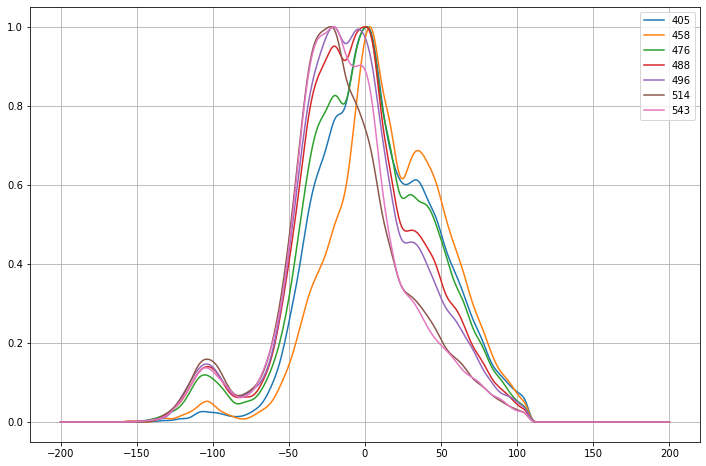

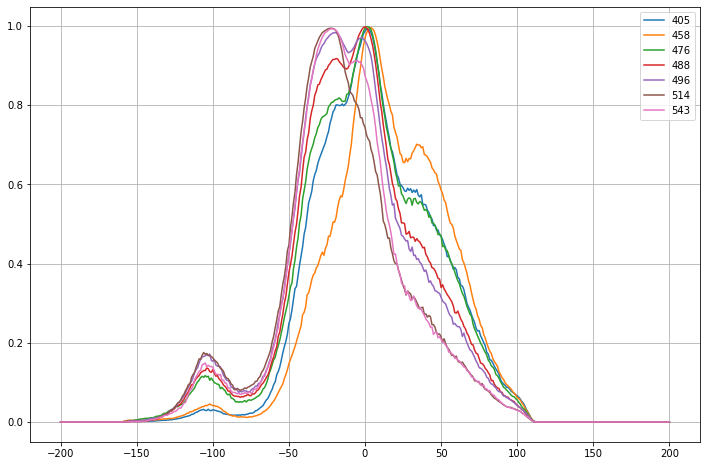

In [9]:
num = 0
sample = np.array(x[num]).reshape(((1, 2807)))
prediction = autoencoder_model(sample, training=False).numpy().flatten()

plot_sp(x[num])
plot_sp(prediction)

In [10]:
transformed_x[0]

array([-0.99266183, -0.99729055,  3.075067  , -0.9794937 , -0.605777  ,
       -0.9938787 ,  3.8848064 ,  1.2573565 , -0.8114589 ,  7.2926555 ,
       -0.99889183,  5.5185986 , -0.87234104,  4.1647778 , -0.99870414,
        2.7585442 , -0.99723065,  5.9743266 , -0.9997629 , -0.7418927 ,
        1.358774  ,  6.064234  , -0.9993083 , -0.04230851, -0.9706859 ,
       -0.073421  ,  1.3022487 ,  1.5708218 , -0.99760276, -0.9993394 ,
        3.66295   , -0.96893966,  5.375111  , -0.9978033 ,  4.923403  ,
        3.936654  , -0.9998771 , -0.9984808 ,  5.5795774 , -0.9999721 ,
       -0.99987954, -0.999131  ,  6.2617345 ,  1.9881719 , -0.86038584,
        4.32771   , -0.9869506 ,  1.0124575 , -0.7454656 ,  7.174304  ,
       -0.9430481 , -0.405627  ,  2.9615297 , -0.99927145,  7.974781  ,
       -0.76618207,  3.1820464 , -0.9979615 ,  3.1741073 ,  7.663921  ,
        6.1466684 , -0.9977458 , -0.99809605,  0.6131362 ], dtype=float32)

In [11]:
df = pd.DataFrame(transformed_x).T

In [12]:
import statsmodels.api as sm
sm.stats.diagnostic.normal_ad(df[59])

(4.171831399489562, 1.7195907201502868e-10)

In [13]:
fdf = pd.DataFrame()
fdf['mean'] = df.mean(axis=1)
fdf['median'] = df.median(axis=1)
fdf['min'] = df.min(axis=1)
fdf['max'] = df.max(axis=1)
fdf['range'] = fdf['max'] - fdf['min']
fdf['std_dev'] = df.std(axis=1)

In [14]:
with pd.option_context('display.max_rows', None,):
    print(fdf.sort_values(by='std_dev', ascending=False))

        mean    median       min        max      range   std_dev
59  5.186203  4.286103 -0.749348  13.634843  14.384192  3.734059
38  5.065187  4.675764 -0.852354  15.828714  16.681068  3.460859
9   5.314063  5.012269 -0.744578  15.720603  16.465181  3.329548
60  6.388295  7.490508 -0.630768  13.558391  14.189158  3.271975
6   3.519131  3.566488 -0.997535  14.352055  15.349590  3.168456
58  2.306315  1.722854 -0.979052  14.648397  15.627449  3.061054
32  5.725231  6.316377 -0.967861  10.495151  11.463012  2.555536
8   0.304233 -0.853090 -0.994210  12.245433  13.239642  2.524314
42  5.356998  5.110942 -0.785899  13.364835  14.150734  2.462658
25  2.489779  3.021027 -0.998511   8.675647   9.674158  2.452663
34  5.031476  4.858825 -0.999238  11.675266  12.674503  2.423459
13  2.960796  2.750903 -0.947535   9.917129  10.864663  2.391432
21  7.012331  7.514291 -0.954434  11.104239  12.058674  2.363825
11  5.797557  5.954314 -0.983175  11.022033  12.005207  2.356703
56  3.814904  3.618156 -0

array([[<AxesSubplot:title={'center':'std_dev'}>]], dtype=object)

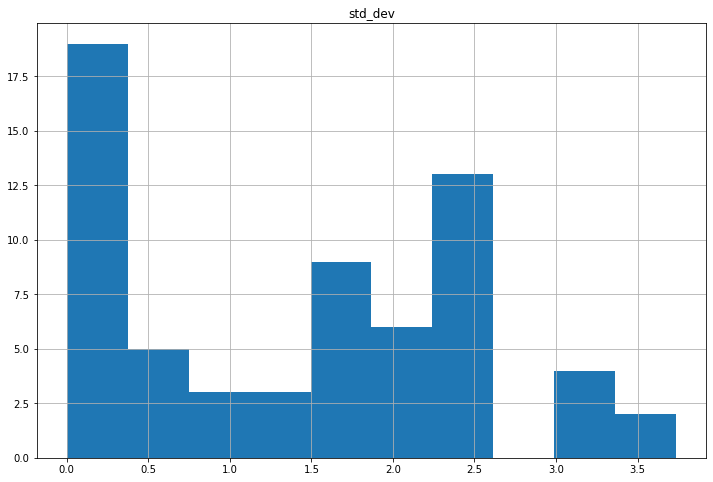

In [14]:
fdf.hist(column='std_dev', bins=10, figsize=(12, 8))

In [15]:
# codes = encoder.predict(x_test)
# sns.jointplot(codes[:,1], codes[:,3])

## Исследование группы признаков 

In [15]:
def decode(feature_vector):
    sample = np.array(feature_vector).reshape(((1, 64)))
    prediction = decoder_model(sample, training=False).numpy().flatten()
    return prediction

In [16]:
def change_plot(num, feature, n_changes):
    feature_vector = transformed_x[num].copy()

    min_val = float(fdf.loc[[feature]]['min'])
    max_val = float(fdf.loc[[feature]]['max'])

#     print(f'current = {feature_vector[feature]} min = {min_val} max = {max_val}')
    print(f'feature {feature}\n current = {feature_vector[feature]} \n min = {min_val} \n max = {max_val}')

    changes = np.linspace(min_val,
                          max_val, 
                          n_changes)

    plot_sp(decode(feature_vector))

    for new_feature in changes:
        feature_vector[59] = new_feature
        plot_sp(decode(feature_vector))

current = 8.334366798400879 
 min = 59   -0.749348
Name: min, dtype: float32 
 max = 59    13.634843
Name: max, dtype: float32


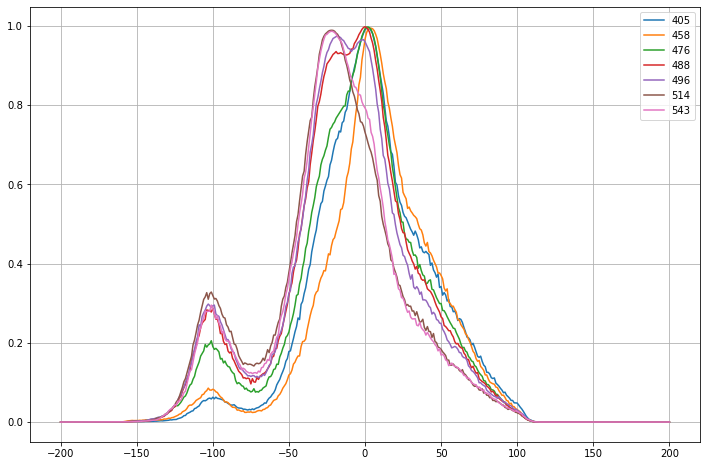

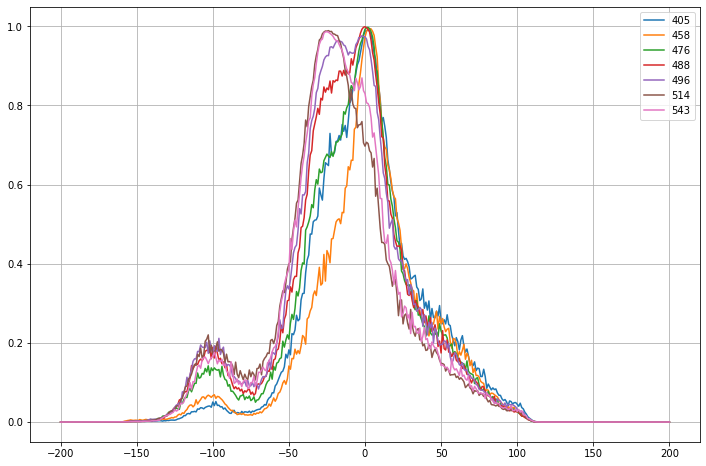

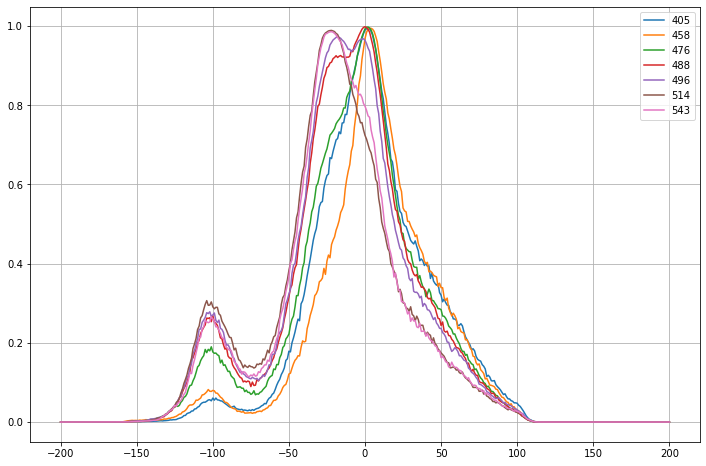

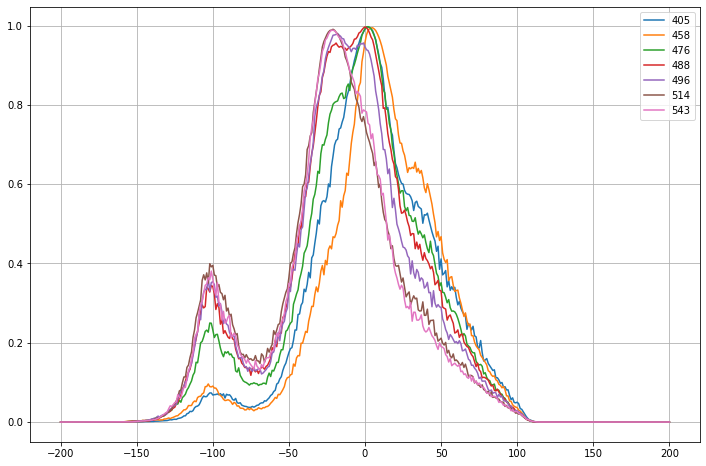

In [19]:
num = 176
feature = 59
feature_vector = transformed_x[num].copy()

print(f"current = {feature_vector[feature]} \n min = {fdf.loc[[feature]]['min']} \n max = {fdf.loc[[feature]]['max']}")
changes = np.linspace(fdf.loc[[59]]['min'],
                      fdf.loc[[59]]['max'], 
                      3)
# plot_sp(x[num])
plot_sp(decode(feature_vector))

for new_feature in changes:
    feature_vector[59] = new_feature
    plot_sp(decode(feature_vector))


Отвечает за "бугорок" левее точки -100

похоже на высоту лазеров с большой длиной волны, но из-за погрешностей не скажешь однозначно

шум выше, когда он дальше от изначального значения и при экстримальных значениях -> признак работает в связке с другими

current = -0.44268798828125 min = 38   -0.852354
Name: min, dtype: float32 max = 38    15.828714
Name: max, dtype: float32


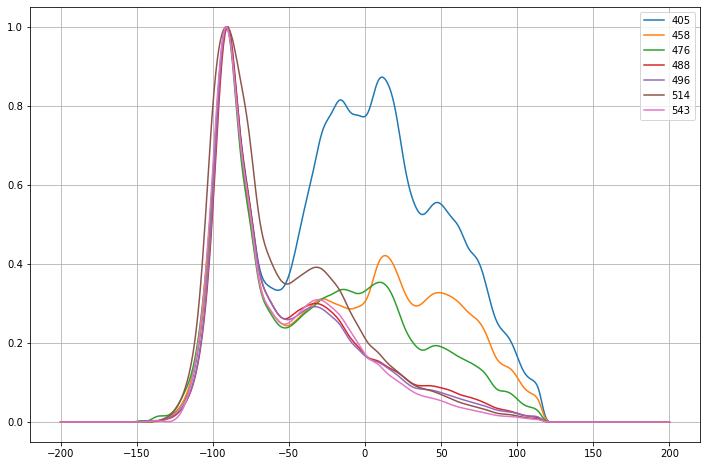

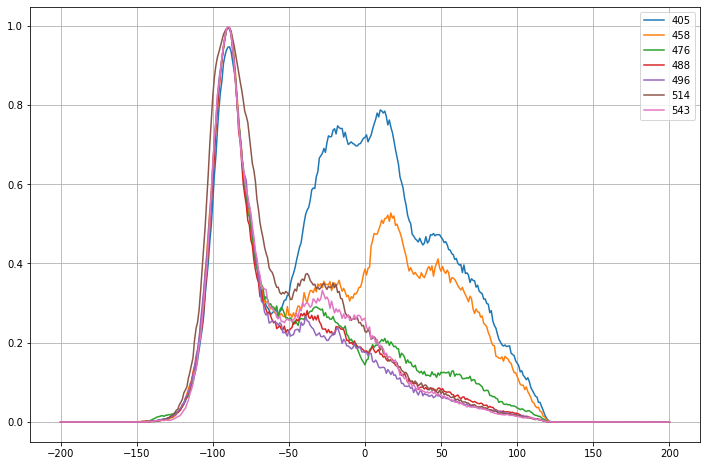

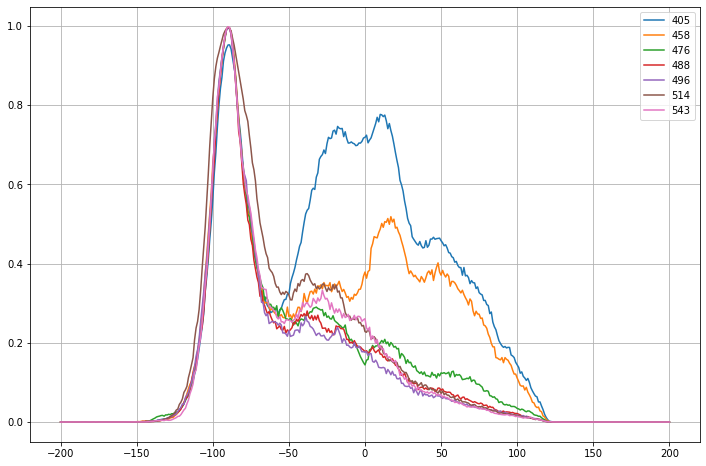

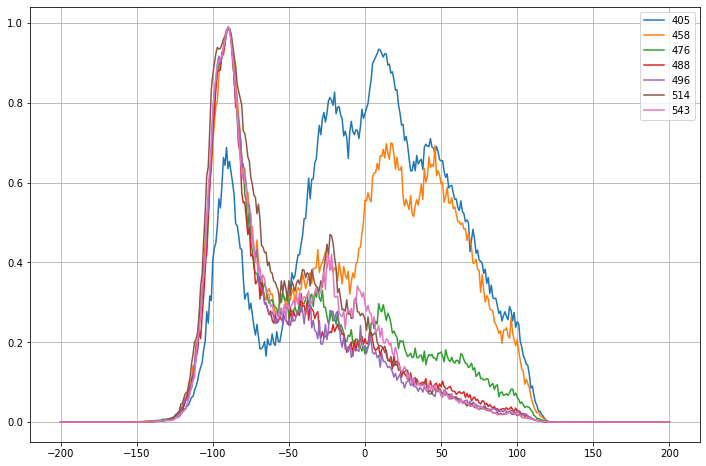

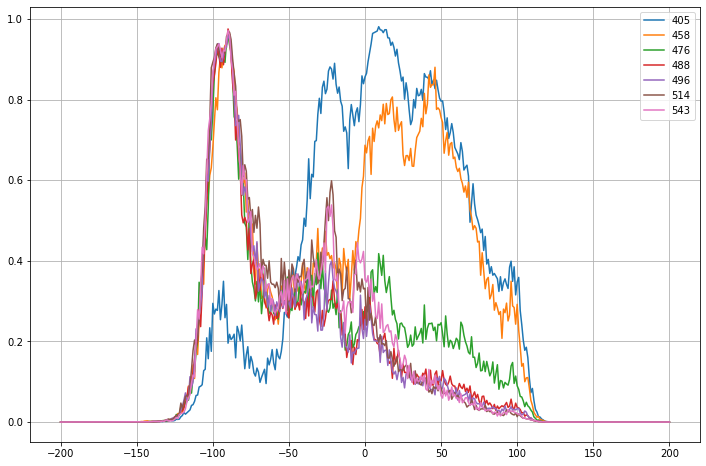

In [103]:
num = 129
feature = 38
feature_vector = transformed_x[num].copy()

min_val = fdf.loc[[feature]]['min']
max_val = fdf.loc[[feature]]['max']

print(f'current = {feature_vector[feature]} min = {min_val} max = {max_val}')

changes = np.linspace(min_val,
                      max_val, 
                      3)
plot_sp(x[num])
plot_sp(decode(feature_vector))

for new_feature in changes:
    feature_vector[feature] = new_feature
    plot_sp(decode(feature_vector))

сильнее влияет при маленькой длине волны, особенно на синий

S:\Anaconda\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


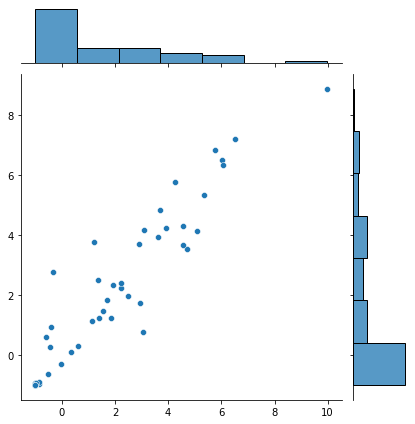

In [24]:
import seaborn as sns
sns.jointplot(transformed_x[:][59], transformed_x[:][38])

In [ ]:
main_features = pd.DataFrame()
for i in [59, 38, 9, 60, 6, 58]:
    main_features[str(i)] = transformed_x[:][i]
main_features

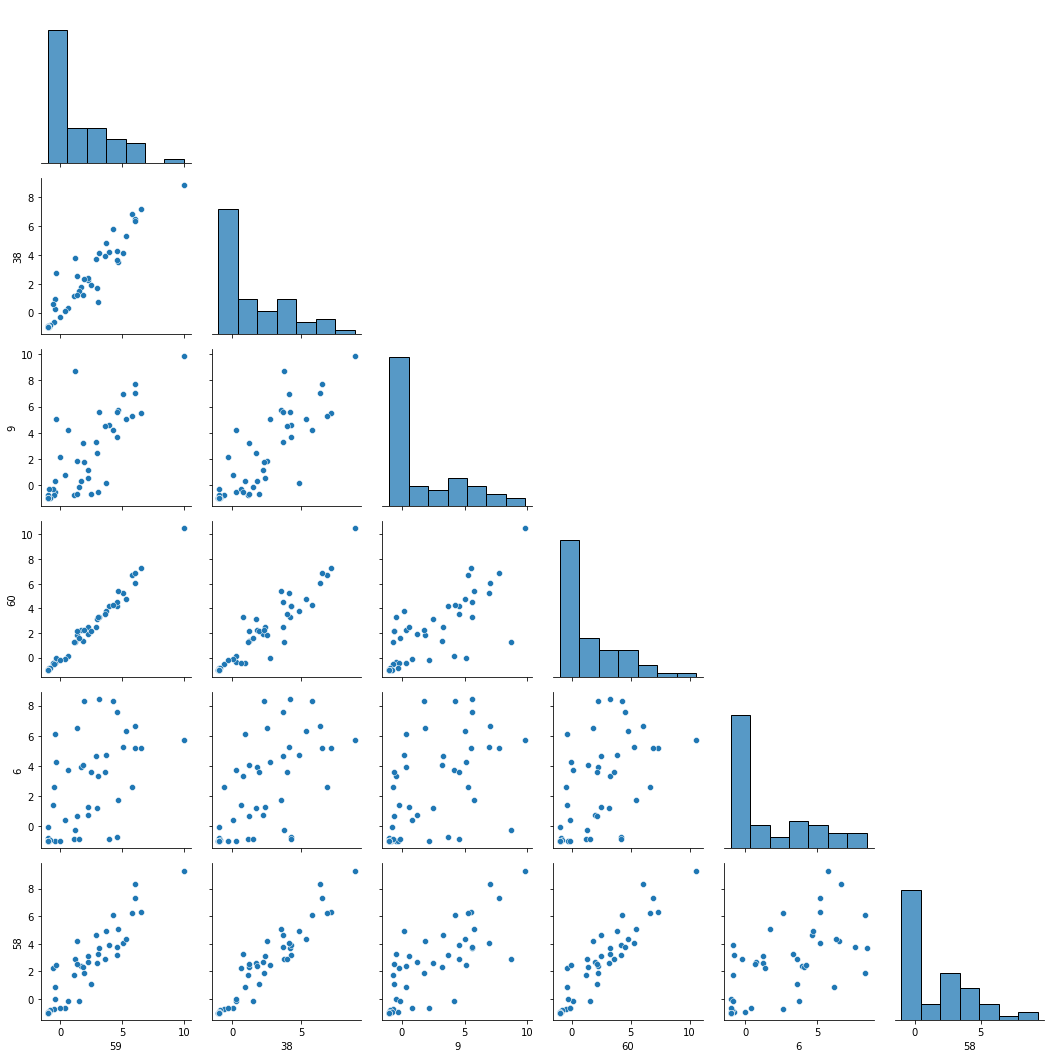

In [29]:
g = sns.PairGrid(main_features, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

линейная зависимость:
- 60 38
- 58 38
- 58 59
- 59 38

сильная линейная зависимость:
- 60 59

нет заметных зависимостей:
- 6

In [49]:
print('\t', end='')
for j in [59, 38, 9, 60, 6, 58]:
    print(j, end='\t')
print()

for i in [59, 38, 9, 60, 6, 58]:
    print(i, end='\t')
    for j in [59, 38, 9, 60, 6, 58]:
        print(np.round(np.corrcoef(transformed_x[:][i], transformed_x[:][j])[0][1], 2), end='\t')
    print()

	59	38	9	60	6	58	
59	1.0	0.96	0.83	0.99	0.69	0.94	
38	0.96	1.0	0.87	0.95	0.73	0.96	
9	0.83	0.87	1.0	0.83	0.65	0.83	
60	0.99	0.95	0.83	1.0	0.68	0.95	
6	0.69	0.73	0.65	0.68	1.0	0.75	
58	0.94	0.96	0.83	0.95	0.75	1.0	


In [17]:
def change_plot_several(num, features, n_changes):
    feature_vector = transformed_x[num].copy()
    plot_sp(decode(feature_vector))
    changes = {}
    for feature in features:
        min_val = float(fdf.loc[[feature]]['min'])
        max_val = float(fdf.loc[[feature]]['max'])
        print(f'feature {feature}\n current = {feature_vector[feature]} \n min = {min_val} \n max = {max_val}')
        
        rang = max_val - min_val
        changes[feature] = np.linspace(min_val+rang if feature==60 else max_val-rang,
                                      max_val-rang if feature==60 else min_val+rang, 
                                      n_changes)
    
    for i in range(n_changes):
        for feature in features:
            feature_vector[feature] = changes[feature][i]
        plot_sp(decode(feature_vector))

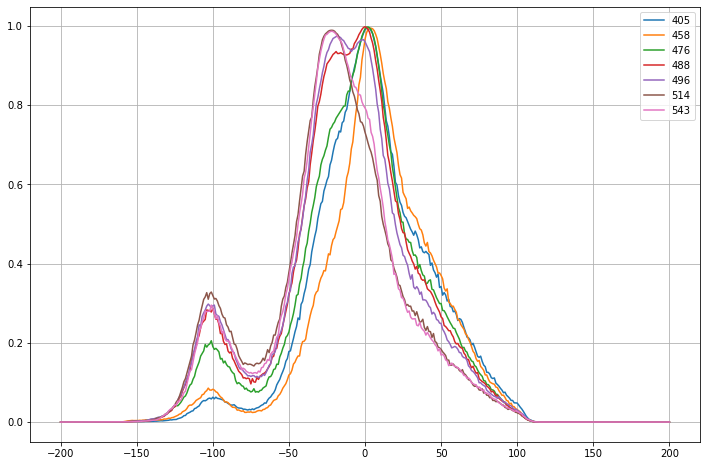

feature 59
 current = 8.334366798400879 
 min = -0.7493481636047363 
 max = 13.634842872619629
feature 60
 current = 2.9999072551727295 
 min = -0.6307680606842041 
 max = 13.558390617370605


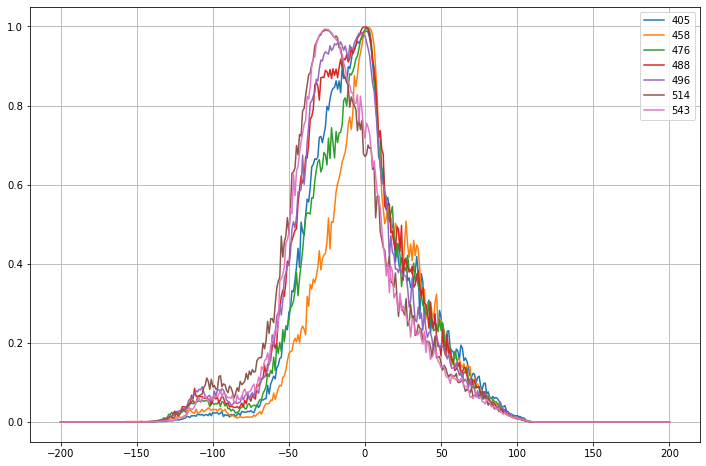

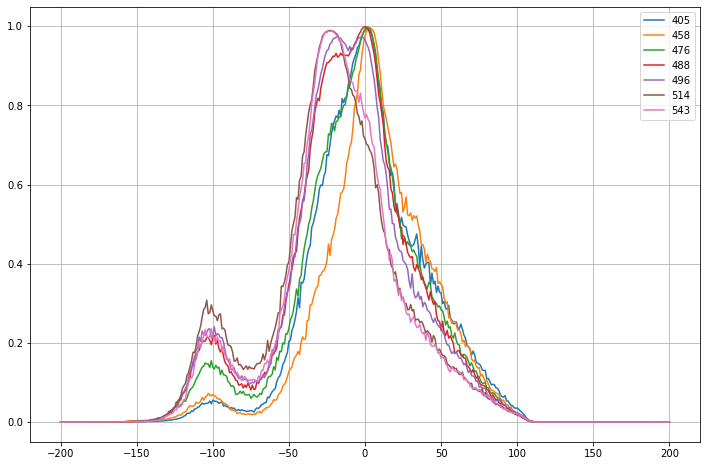

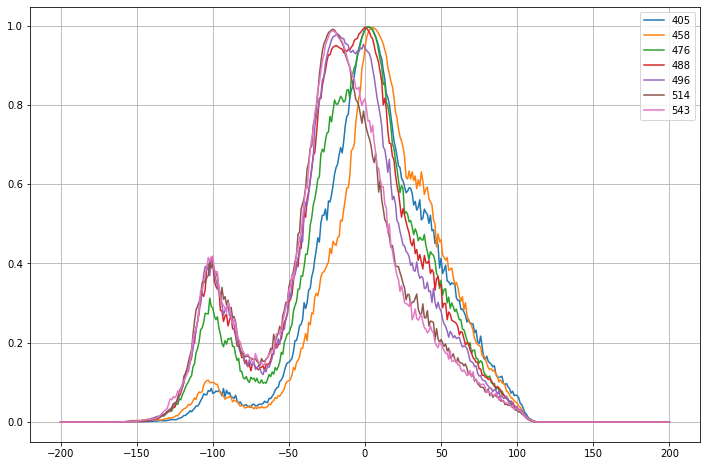

In [19]:
change_plot_several(176, [59, 60], 3)

результат похож на отдельный признак 59, но уже сильнее влияющий на лазеры с меньшей длиной волны, в сумме отвечают за высоту пика у -100

теперь рассмотрим 6 признак

feature 6
 current = -0.8032100796699524 
 min = -0.9975354075431824 
 max = 14.352054595947266


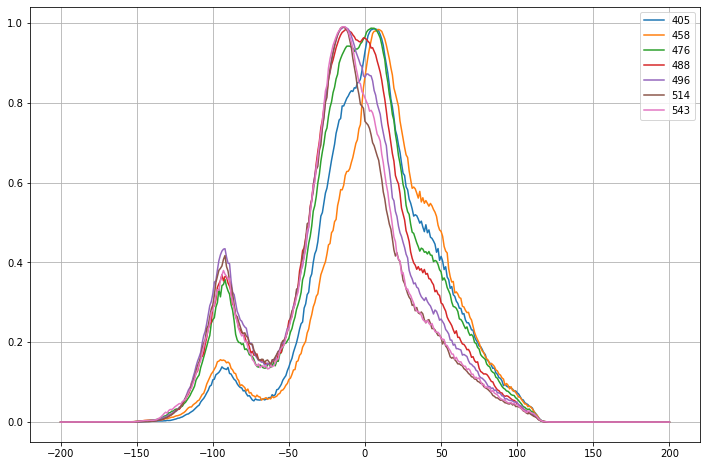

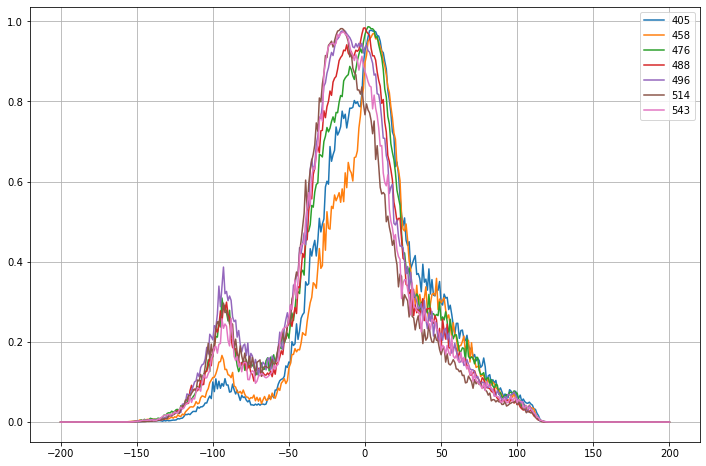

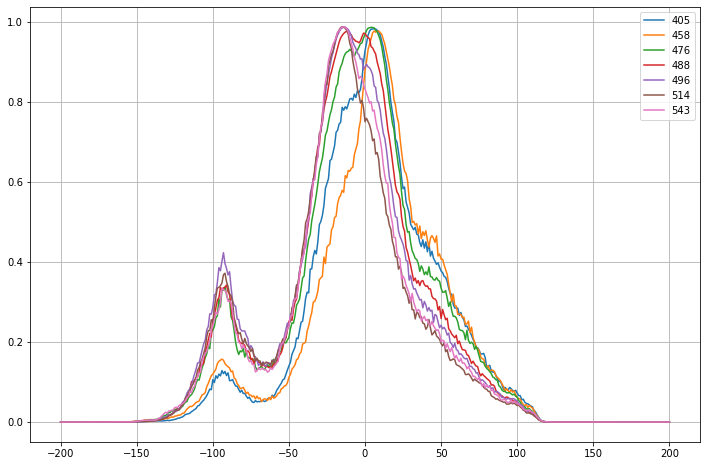

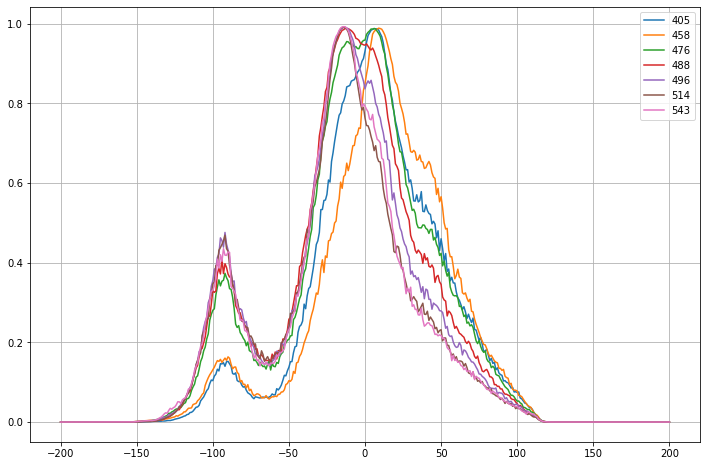

In [25]:
change_plot(177, 6, 3)

влияет на плотность линий спектров на 25;100

9 признак значимо коррелирует со всеми ост кроме 6, но его изменение по отдельности не дало понять за что он отвечает

In [83]:
def change_plot_several(num, features, n_changes):
    feature_vector = transformed_x[num].copy()
    plot_sp(decode(feature_vector))
    changes = {}
    for feature in features:
        min_val = float(fdf.loc[[feature]]['min'])
        max_val = float(fdf.loc[[feature]]['max'])
        print(f'feature {feature}\n current = {feature_vector[feature]} \n min = {min_val} \n max = {max_val}')
        
        rang = max_val - min_val
        changes[feature] = np.linspace(min_val+rang,
                                      max_val-rang, 
                                      n_changes)
    
    for i in range(n_changes):
        for feature in features:
            feature_vector[feature] = changes[feature][i]
        plot_sp(decode(feature_vector))

## Исследование 2 группы признаков

feature 32
 current = 10.495150566101074 
 min = -0.9678612947463989 
 max = 10.495150566101074


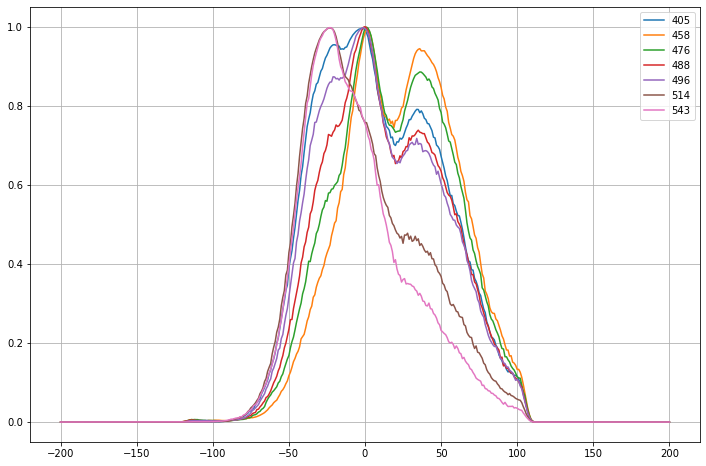

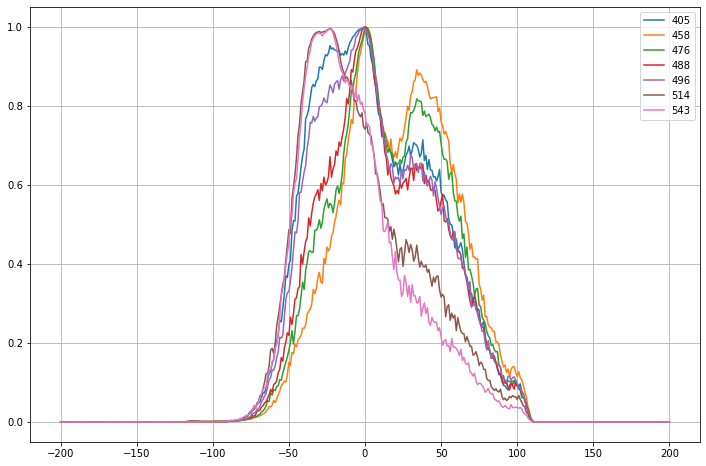

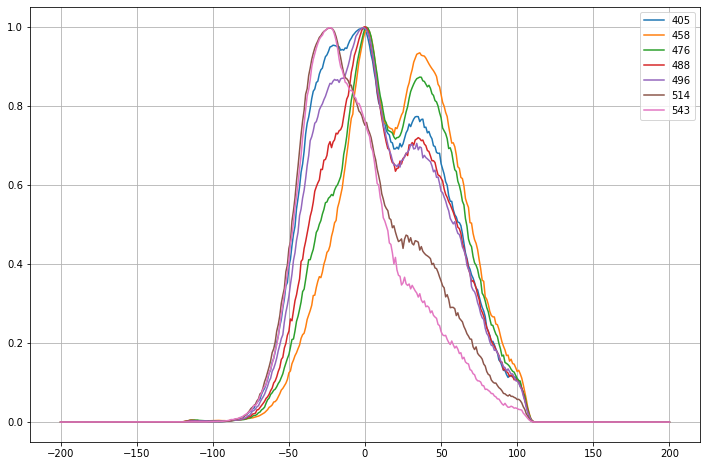

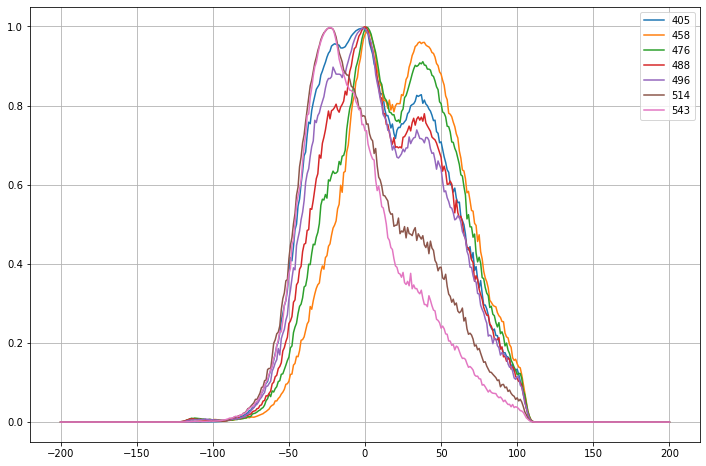

In [70]:
change_plot(238, 32, 3)#8 42 / 347 3 пика

32 признак влияет на 3 пик в районе точки 40, сильнее влияет на желтый цвет и зеленый

feature 8
 current = 12.24543285369873 
 min = -0.9942096471786499 
 max = 12.24543285369873


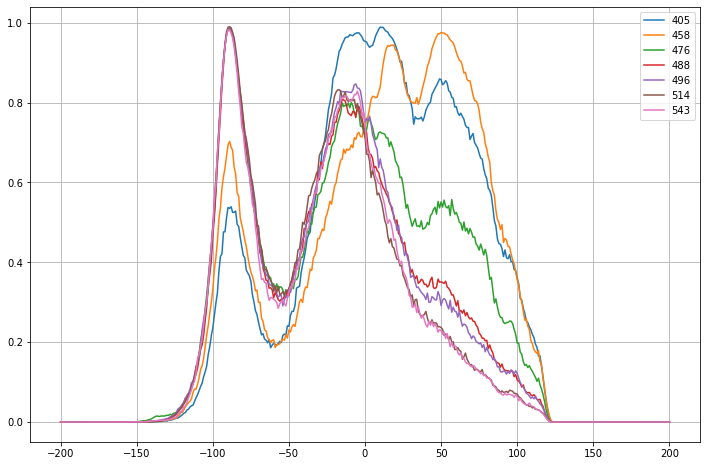

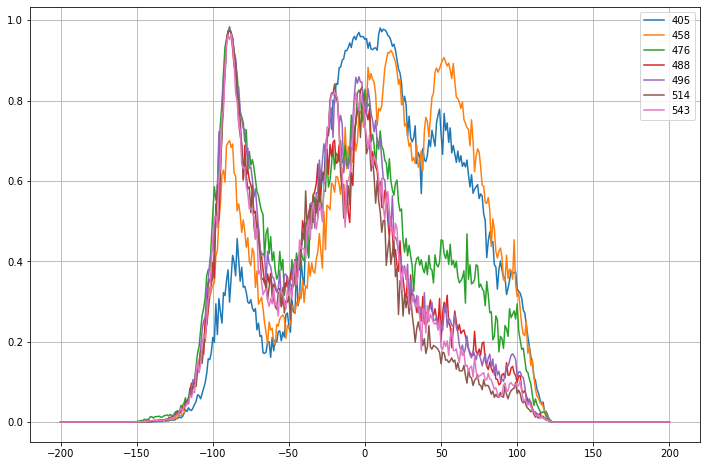

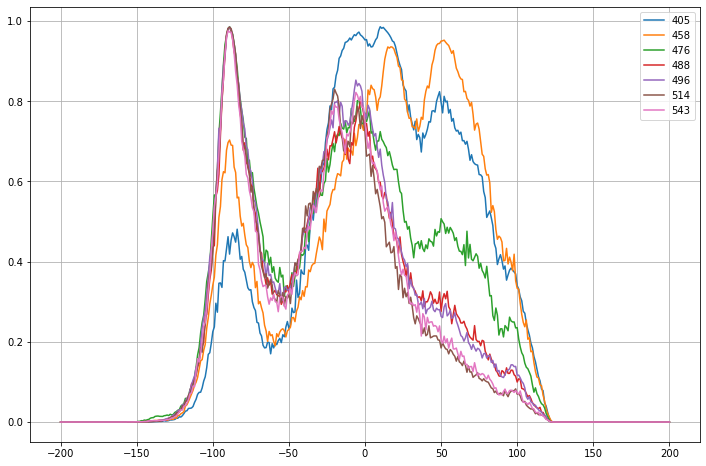

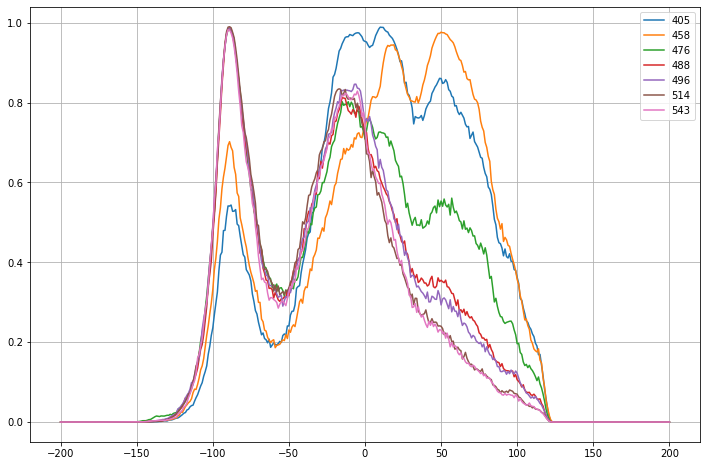

In [68]:
change_plot(139, 8, 3)#8 42 / 347 3 пика

8 признак влияет на 3 пик в районе точки 40, сильнее влияет на желтый цвет и синий

ниже: 42 признак сильнее всего выражен у образца 205, но его отдельное изменение ни к чему не привело

feature 42
 current = 13.364834785461426 
 min = -0.7858989834785461 
 max = 13.364834785461426


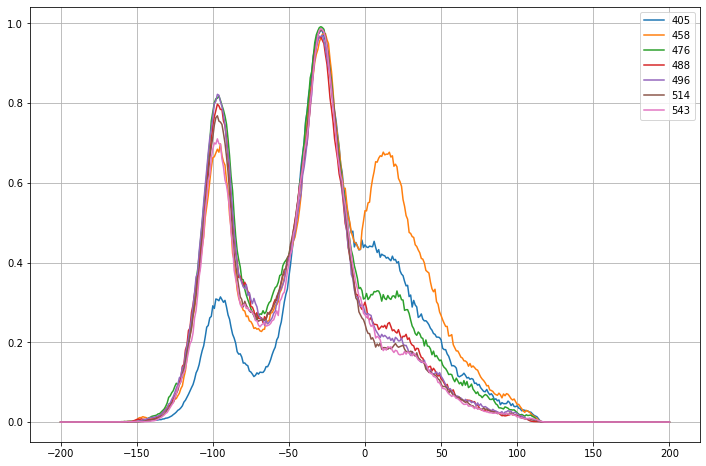

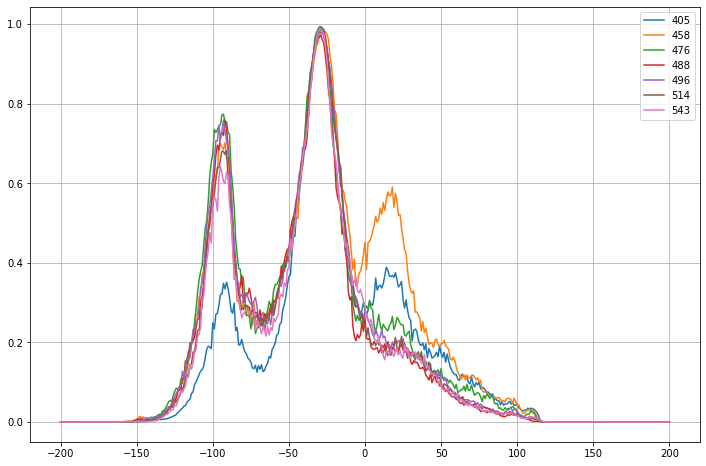

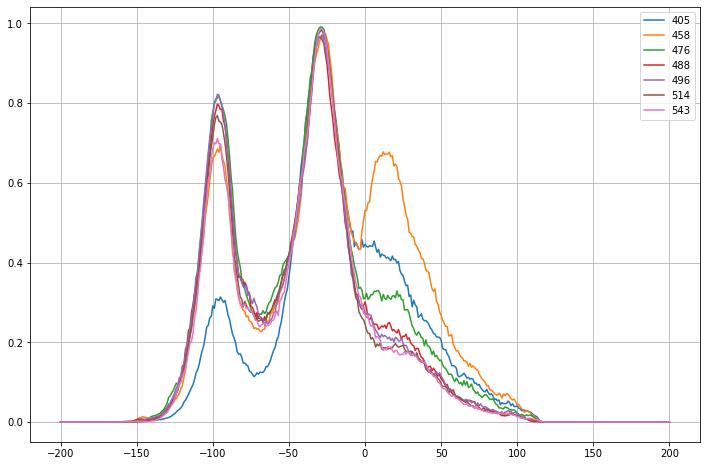

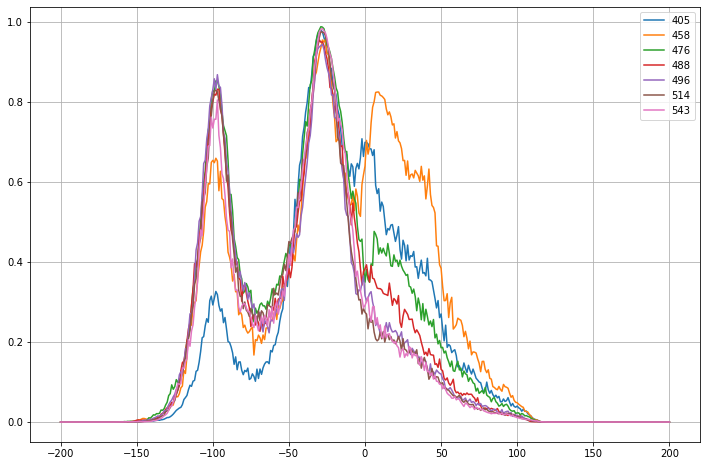

In [76]:
change_plot(205, 42, 3)#8 42 / 347 3 пика

In [72]:
df.iloc[42].argmax()

205

In [75]:
dft = df.T
dft.iloc[135].argmax()

8

## Исследование признаков с наименьшим стандартным отклонением

In [29]:
least_features = [31, 3, 62, 5, 22, 41, 53, 28, 40, 37, 29, 1, 36, 14, 39, 33, 61]

In [30]:
print('\t', end='')
for j in least_features:
    print(j, end='\t')
print()

for i in least_features:
    print(i, end='\t')
    for j in least_features:
        print(np.round(np.corrcoef(transformed_x[:][i], transformed_x[:][j])[0][1], 2), end='\t')
    print()

	31	3	62	5	22	41	53	28	40	37	29	1	36	14	39	33	61	
31	1.0	0.65	0.8	0.54	0.84	0.95	0.8	0.83	0.99	0.94	0.78	0.58	0.94	0.79	0.96	0.84	0.84	
3	0.65	1.0	0.75	0.96	0.82	0.76	0.8	0.79	0.65	0.73	0.8	0.98	0.67	0.81	0.71	0.68	0.8	
62	0.8	0.75	1.0	0.74	0.96	0.92	0.98	0.95	0.81	0.93	0.93	0.72	0.87	0.99	0.89	0.94	0.98	
5	0.54	0.96	0.74	1.0	0.82	0.7	0.81	0.79	0.57	0.69	0.8	0.98	0.63	0.81	0.65	0.67	0.78	
22	0.84	0.82	0.96	0.82	1.0	0.95	0.99	0.98	0.87	0.95	0.97	0.81	0.93	0.98	0.93	0.94	0.99	
41	0.95	0.76	0.92	0.7	0.95	1.0	0.93	0.94	0.96	0.98	0.92	0.73	0.98	0.92	0.99	0.93	0.96	
53	0.8	0.8	0.98	0.81	0.99	0.93	1.0	0.97	0.82	0.93	0.97	0.79	0.9	0.99	0.91	0.95	0.99	
28	0.83	0.79	0.95	0.79	0.98	0.94	0.97	1.0	0.84	0.95	0.97	0.79	0.91	0.98	0.92	0.88	0.98	
40	0.99	0.65	0.81	0.57	0.87	0.96	0.82	0.84	1.0	0.95	0.8	0.59	0.96	0.81	0.97	0.88	0.85	
37	0.94	0.73	0.93	0.69	0.95	0.98	0.93	0.95	0.95	1.0	0.89	0.69	0.98	0.93	0.99	0.93	0.94	
29	0.78	0.8	0.93	0.8	0.97	0.92	0.97	0.97	0.8	0.89	1.0	0.82	0.9	0.95	0.88	0.89	0.97	
1

- признаки лишние
- важны в комбинации с другими

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [32]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(encoder.classes_)

[ 398  457  535  550  601  624  666  756  824 1072 1126 1315 1336 1409
 1415 1416 1712 1713 1715 1718 1750 1763 1804 1817]


In [33]:
removed_least_x = transformed_x.copy()
for i in removed_least_x:
    for feature in least_features:
        i[feature] = 0

print(removed_least_x[0])

[-0.99266183  0.          3.075067    0.         -0.605777    0.
  3.8848064   1.2573565  -0.8114589   7.2926555  -0.99889183  5.5185986
 -0.87234104  4.1647778   0.          2.7585442  -0.99723065  5.9743266
 -0.9997629  -0.7418927   1.358774    6.064234    0.         -0.04230851
 -0.9706859  -0.073421    1.3022487   1.5708218   0.          0.
  3.66295     0.          5.375111    0.          4.923403    3.936654
  0.          0.          5.5795774   0.          0.          0.
  6.2617345   1.9881719  -0.86038584  4.32771    -0.9869506   1.0124575
 -0.7454656   7.174304   -0.9430481  -0.405627    2.9615297   0.
  7.974781   -0.76618207  3.1820464  -0.9979615   3.1741073   7.663921
  6.1466684   0.          0.          0.6131362 ]


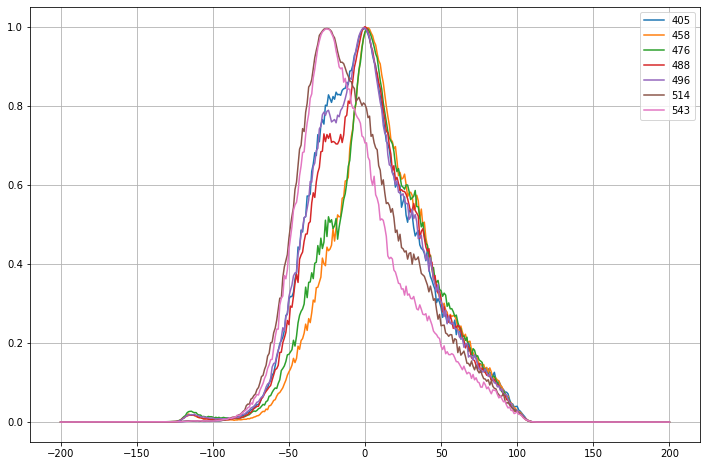

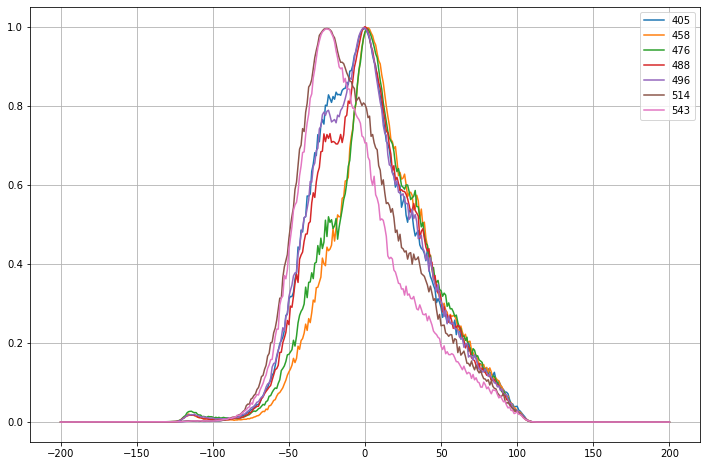

In [36]:
sample = removed_least_x[24].reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(decode(transformed_x[24]))
plot_sp(prediction)

In [120]:
x_train, x_test, y_train, y_test = train_test_split(removed_least_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)

print(np.asarray(x_train).shape,
      np.asarray(x_test).shape,
      np.asarray(y_train).shape,
      np.asarray(y_test).shape)

(411, 64) (137, 64) (411,) (137,)


In [121]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
svm_prediction = svm.predict(x_test)
print(accuracy_score(svm_prediction, y_test))
print(classification_report(svm_prediction, y_test))

0.9197080291970803
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       1.00      1.00      1.00         6
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         3
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       0.00      0.00      0.00         0
          12       0.71      0.83      0.77         6
          13       1.00      1.00      1.00         2
          14       0.83      1.00      0.91         5
          15       1.00      0.80      0.89         5
          16       1.00      1.00      1.00        10
        

S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Результаты не изменились, данные признаки бесполезны при классификации

### Исследование декодера

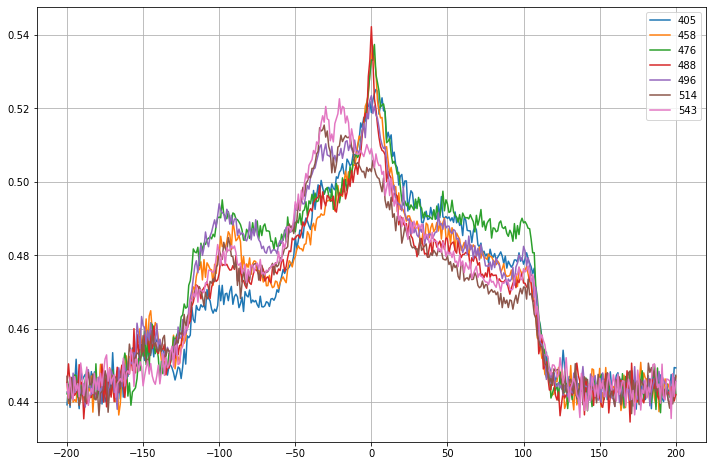

In [18]:
sample = np.zeros(64).reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(prediction)

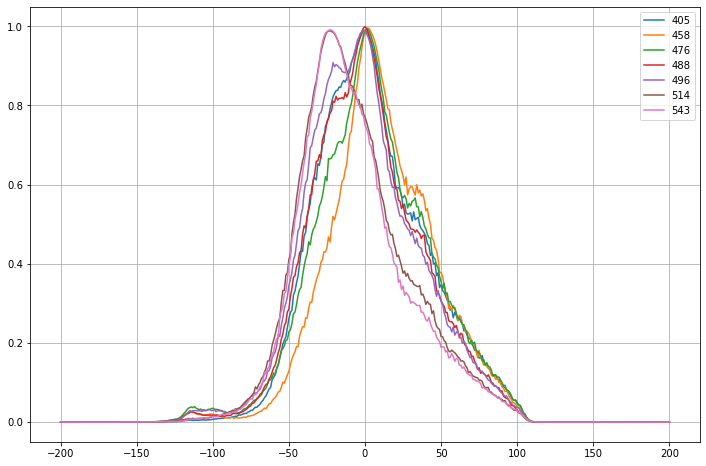

In [22]:
sample = fdf['mean'].to_numpy('float64').reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(prediction)

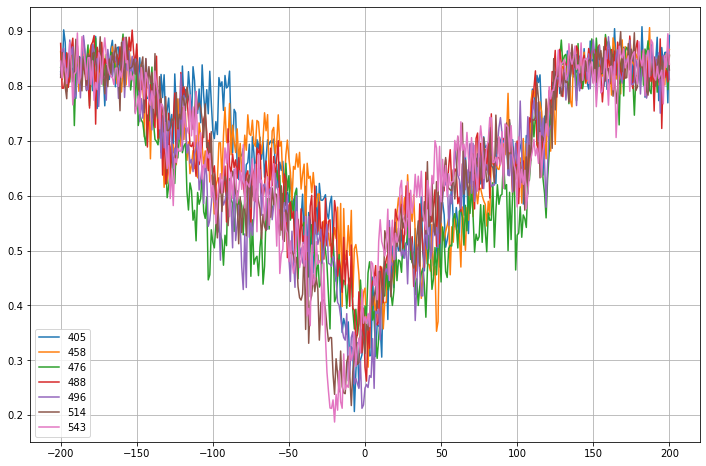

In [24]:
sample = fdf['min'].to_numpy('float64').reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(prediction)

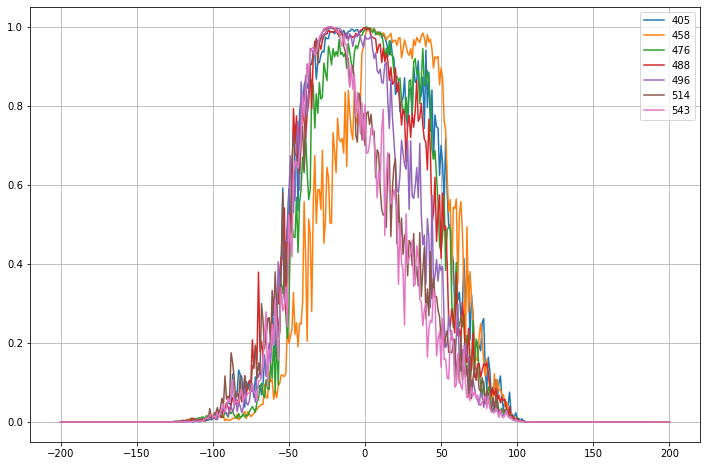

In [25]:
sample = fdf['max'].to_numpy('float64').reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(prediction)

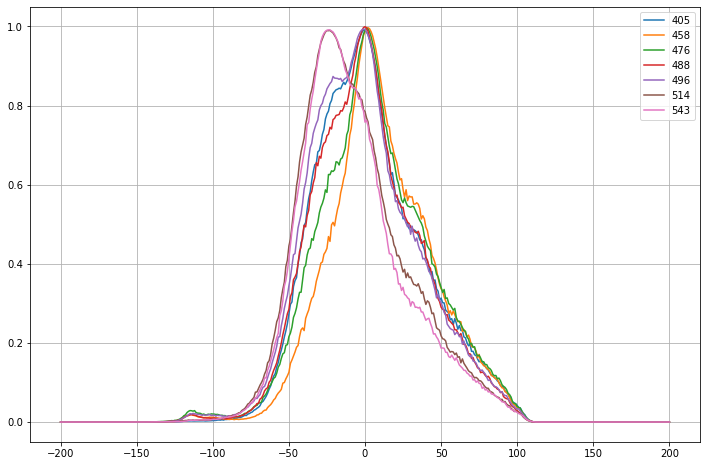

In [26]:
sample = fdf['median'].to_numpy('float64').reshape(((1, 64)))
prediction = decoder_model(sample, training=False).numpy().flatten()
plot_sp(prediction)